# Trabalho 1 de Finanças 2
#### Professor Samy Dana
<div style="text-align: right">Arnon Golias Pessoa Mendes  

Gustavo Pohlmann Gonzaga  

Julia Costa Godoy  

Lucas Graça Fontolan  

Rafael Rezende de Carvalho  

Viviane Matias da Costa Cervantes Buglio</div>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # Gráficos
import seaborn as sns
import statsmodels.api as sm # forecast
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.tsa as tsa

In [128]:
# importando as séries históricas desde 1994
sh = pd.read_excel(r"C:\Users\Pohlmann\Documents\FGV\9º Semestre\Fin2\Base Dados RF x RV.xlsx", sheet_name="OneinAll", index_col=0)
shus = pd.read_excel(r"C:\Users\Pohlmann\Documents\FGV\9º Semestre\Fin2\Base Dados RF x RV.xlsx", sheet_name="US", index_col=0)
sh.head()

,CDI_Ano,IBOV,CDI_Dia,IBOV_DIA,CDIB1,IBOVB1
Data,,,,,,
1994-07-01,149.642900,3623.1,0.003637,0.000000,1.000000,1.000000
1994-07-04,172.091812,3580.8,0.003980,-0.011675,1.003980,0.988325
1994-07-05,173.255310,3564.3,0.003997,-0.004608,1.007993,0.983771
1994-07-06,173.461151,3753.5,0.004000,0.053082,1.012025,1.035991
1994-07-07,171.409714,3904.9,0.003970,0.040336,1.016043,1.077779


In [129]:
# garatindo sorting do datetimeindex
sh.sort_index(inplace=True)
shus.sort_index(inplace=True)

In [58]:
# Limpando eventuais NaNs e ajustando frequência do índice para business days
sh_clean = sh.dropna(subset=['IBOV'], axis=0).sort_index().asfreq("B", method='ffill')

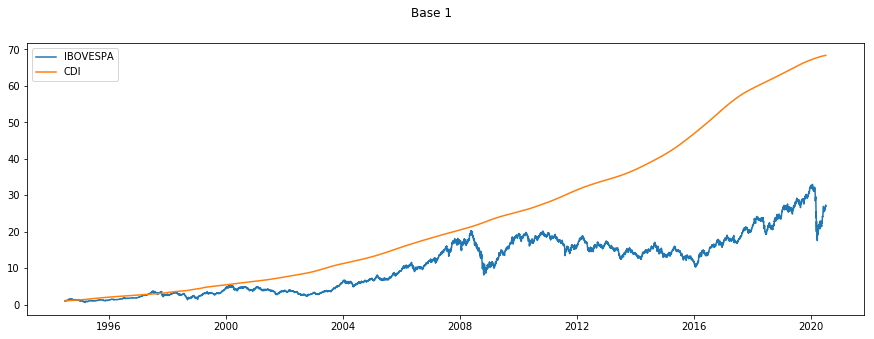

In [85]:
# só para ter certeza de que os dados estão corretos
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(sh.IBOVB1, label="IBOVESPA")
ax.plot(sh.CDIB1, label="CDI")
fig.suptitle("Base 1")
leg = ax.legend()

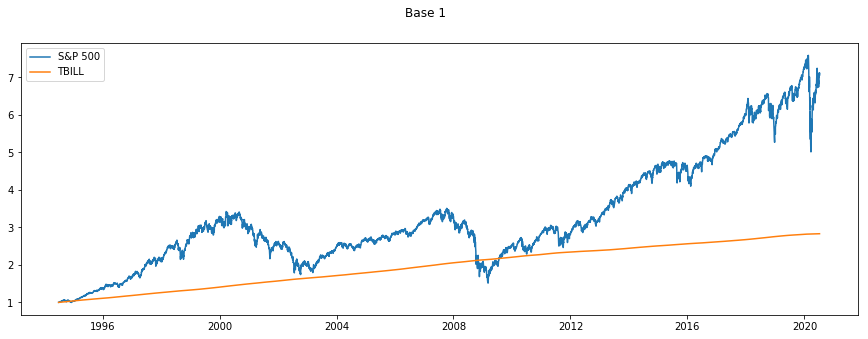

In [131]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(shus.SPXB1, label="S&P 500")
ax.plot(shus.TBILLB1, label="TBILL")
fig.suptitle("Base 1")
leg = ax.legend()

### Modelando retorno nos períodos de 1, 5, 10 e 20 anos

In [167]:
for i in [252, 252*5, 252*10, 252*20]:
    # para cada período, calcule o rendimento para todos os dias possíveis
    # já tirando IR dos retornos dos investimentos
    IBOV = pd.DataFrame(0.85*(sh[i:].reset_index().IBOVB1/sh.reset_index().IBOVB1-1))
    sh['IBOV'+str(i)] = IBOV.set_index(sh.index)
    if i == 252:
        al = 1 - 0.2
    else:
        al = 1 - 0.15
    CDI = pd.DataFrame(al*(sh[i:].reset_index().CDIB1/sh.reset_index().CDIB1-1))
    sh['CDI'+str(i)] = CDI.set_index(sh.index)
    # Apenas um comparativo de qual dos dois é maior. Se >0, RV>RF
    sh['Comparativo'+str(i)] = sh['IBOV'+str(i)]/sh['CDI'+str(i)]-1
sh.head()

,CDI_Ano,IBOV,CDI_Dia,IBOV_DIA,CDIB1,IBOVB1,IBOV252,CDI252,Comparativo252,IBOV1260,...,CDI5040,Comparativo5040,SPX252,TBILL252,SPX1260,TBILL1260,SPX2520,TBILL2520,SPX5040,TBILL5040
Data,,,,,,,,,,,,,,,,,,,,,
1994-07-01,149.642900,3623.1,0.003637,0.000000,1.000000,1.000000,-0.010839,0.515469,-1.021027,1.812775,...,30.076689,-0.605846,1.221381,1.073382,2.992335,1.351930,2.575303,1.726374,3.951838,2.431731
1994-07-04,172.091812,3580.8,0.003980,-0.011675,1.003980,0.988325,0.012059,0.512730,-0.976481,1.864645,...,29.964983,-0.592088,1.219139,1.073334,3.035926,1.351831,2.579650,1.726162,3.936665,2.431292
1994-07-05,173.255310,3564.3,0.003997,-0.004608,1.007993,0.983771,0.008227,0.509975,-0.983867,1.837148,...,29.853161,-0.592807,1.234559,1.073283,2.984072,1.351736,2.587271,1.725949,3.946591,2.430862
1994-07-06,173.461151,3753.5,0.004000,0.053082,1.012025,1.035991,-0.038022,0.507226,-1.074960,1.771900,...,29.741653,-0.616110,1.232174,1.073233,3.019994,1.351640,2.593123,1.725726,3.962814,2.430432
1994-07-07,171.409714,3904.9,0.003970,0.040336,1.016043,1.077779,-0.080083,0.504522,-1.158730,1.737723,...,29.631461,-0.630117,1.213547,1.073186,2.970806,1.351550,2.558566,1.725497,3.931866,2.430006


In [165]:
for i in [252, 252*5, 252*10, 252*20]:
    # para cada período, calcule o rendimento bruto para todos os dias possíveis
    SPX = pd.DataFrame(shus[i:].reset_index().SPXB1/shus.reset_index().SPXB1-1)
    shus['SPX'+str(i)] = SPX.set_index(shus.index)
    TBILL = pd.DataFrame(shus[i:].reset_index().TBILLB1/shus.reset_index().TBILLB1-1)
    shus['TBILL'+str(i)] = TBILL.set_index(shus.index)
    # Apenas um comparativo de qual dos dois é maior. Se >0, RV>RF
    shus['Comparativo'+str(i)] = shus['SPX'+str(i)]/shus['TBILL'+str(i)]-1
shus.head()

,TBILL,SPX,TBILLdaily,SPXdaily,TBILLB1,SPXB1,SPX252,TBILL252,Comparativo252,SPX1260,TBILL1260,Comparativo1260,SPX2520,TBILL2520,Comparativo2520,SPX5040,TBILL5040,Comparativo5040
Date,,,,,,,,,,,,,,,,,,
1994-07-01,7.322,446.20,0.000280,0.000000,1.000000,1.000000,0.221381,0.073382,2.016827,1.992335,0.351930,4.661162,1.575303,0.726374,1.168721,2.951838,1.431731,1.061727
1994-07-04,7.324,446.20,0.000281,0.000000,1.000281,1.000000,0.219139,0.073334,1.988250,2.035926,0.351831,4.786653,1.579650,0.726162,1.175343,2.936665,1.431292,1.051758
1994-07-05,7.297,446.37,0.000280,0.000381,1.000560,1.000381,0.234559,0.073283,2.200735,1.984072,0.351736,4.640799,1.587271,0.725949,1.186477,2.946591,1.430862,1.059312
1994-07-06,7.286,446.13,0.000279,-0.000538,1.000839,0.999843,0.232174,0.073233,2.170336,2.019994,0.351640,4.744488,1.593123,0.725726,1.195213,2.962814,1.430432,1.071272
1994-07-07,7.300,448.38,0.000280,0.005043,1.001119,1.004886,0.213547,0.073186,1.917857,1.970806,0.351550,4.606043,1.558566,0.725497,1.148275,2.931866,1.430006,1.050247


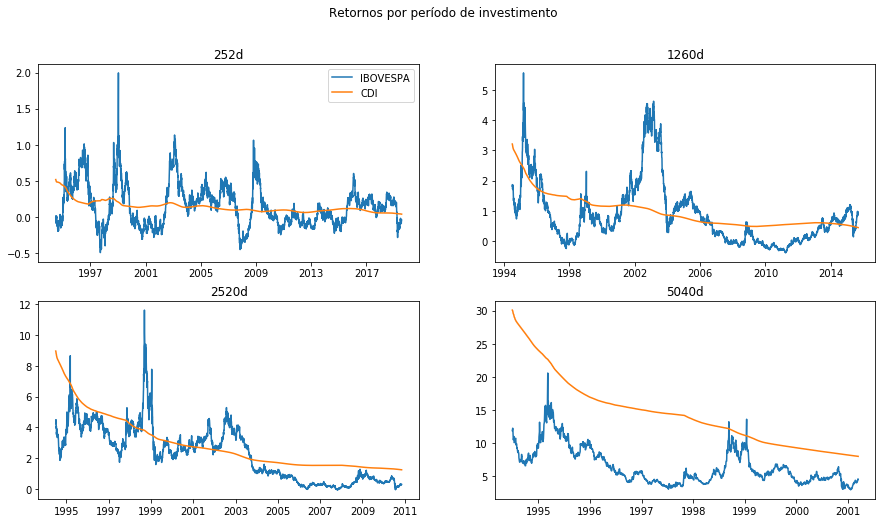

In [168]:
fig, ax = plt.subplots(2,2,figsize=(15,8))
ax[0,0].plot(sh.IBOV252, label="IBOVESPA")
ax[0,0].plot(sh.CDI252, label="CDI")
ax[0,0].set_title('252d')

ax[0,1].plot(sh.IBOV1260, label="IBOVESPA")
ax[0,1].plot(sh.CDI1260, label="CDI")
ax[0,1].set_title('1260d')

ax[1,0].plot(sh.IBOV2520, label="IBOVESPA")
ax[1,0].plot(sh.CDI2520, label="CDI")
ax[1,0].set_title('2520d')

ax[1,1].plot(sh.IBOV5040, label="IBOVESPA")
ax[1,1].plot(sh.CDI5040, label="CDI")
ax[1,1].set_title('5040d')

fig.suptitle("Retornos por período de investimento")
leg = ax[0,0].legend()

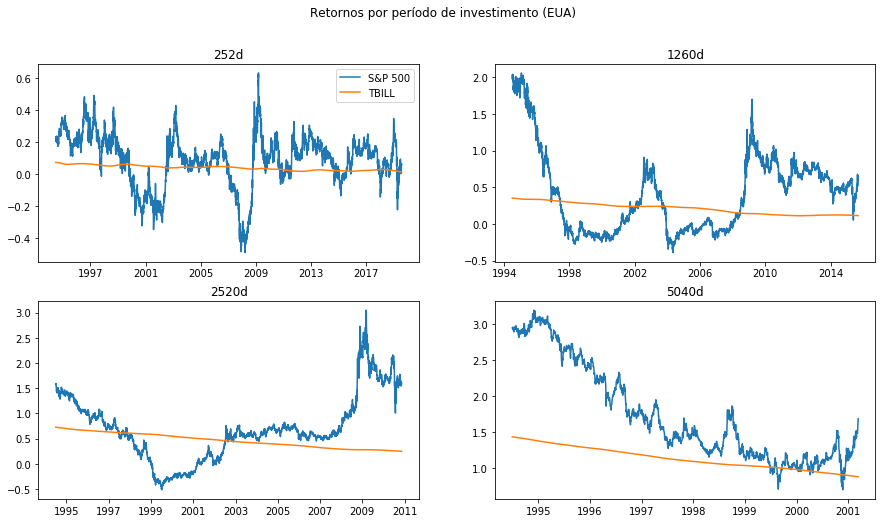

In [166]:
fig, ax = plt.subplots(2,2,figsize=(15,8))
ax[0,0].plot(shus.SPX252, label="S&P 500")
ax[0,0].plot(shus.TBILL252, label="TBILL")
ax[0,0].set_title('252d')

ax[0,1].plot(shus.SPX1260, label="S&P 500")
ax[0,1].plot(shus.TBILL1260, label="TBILL")
ax[0,1].set_title('1260d')

ax[1,0].plot(shus.SPX2520, label="S&P 500")
ax[1,0].plot(shus.TBILL2520, label="TBILL")
ax[1,0].set_title('2520d')

ax[1,1].plot(shus.SPX5040, label="S&P 500")
ax[1,1].plot(shus.TBILL5040, label="TBILL")
ax[1,1].set_title('5040d')

fig.suptitle("Retornos por período de investimento (EUA)")
leg = ax[0,0].legend()

In [149]:
with pd.ExcelWriter(r"C:\Users\Pohlmann\Documents\FGV\9º Semestre\Fin2\BaseGraficos.xlsx") as writer:
    sh.to_excel(writer, sheet_name='BR')
    shus.to_excel(writer, sheet_name='US')

### Forecast

In [248]:
a = sh.IBOV_Base100.sort_index().asfreq("d", method='ffill')

In [146]:
b = sh.SELIC_Base100.sort_index().asfreq("w", method='ffill')

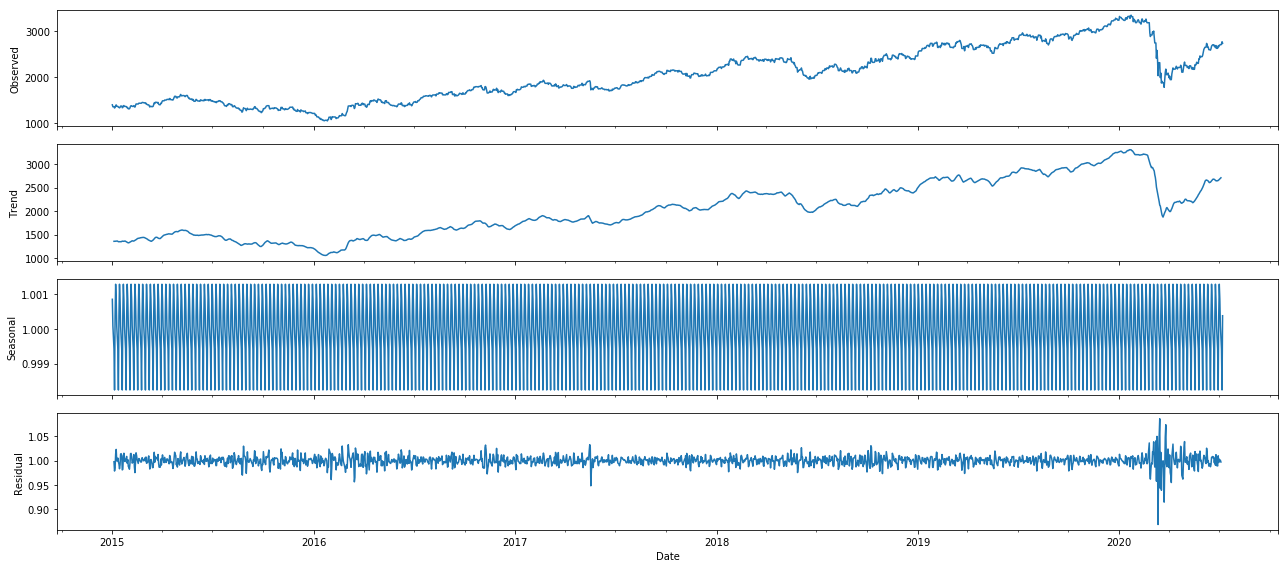

In [249]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(a['2015':], model='multiplicative')
fig = decomposition.plot()
plt.show()

In [258]:
# fit model
model = SARIMAX(a, order=(1, 1, 1), seasonal_order=(1, 1, 1, 90))
model_fit = model.fit(disp=False)
# fit summary
print(model_fit.summary().tables[1])

KeyboardInterrupt: 

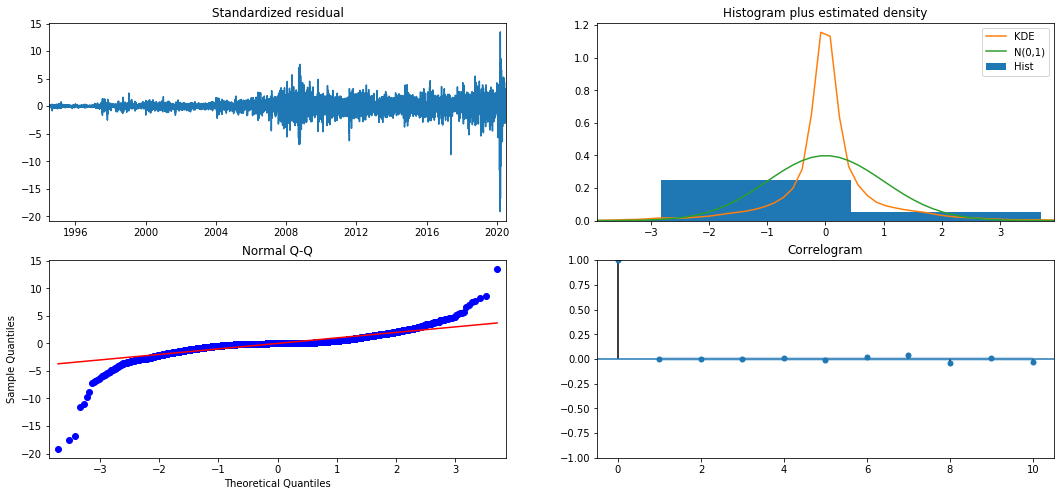

In [251]:
model_fit.plot_diagnostics(figsize=(18, 8))
plt.show()

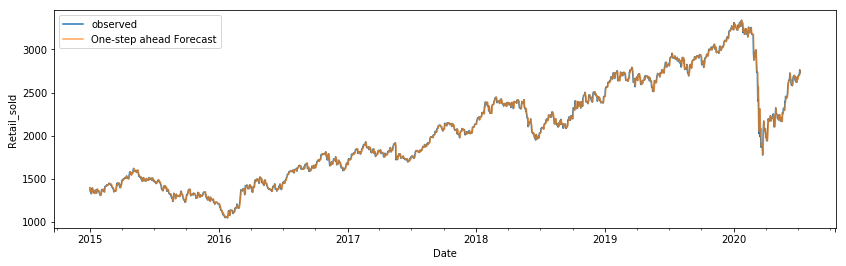

In [252]:
pred = model_fit.get_prediction(dynamic=False)
pred_ci = pred.conf_int()
ax = a['2015':].plot(label='observed')
pred.predicted_mean['2015':].plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Retail_sold')
plt.legend()
plt.show()

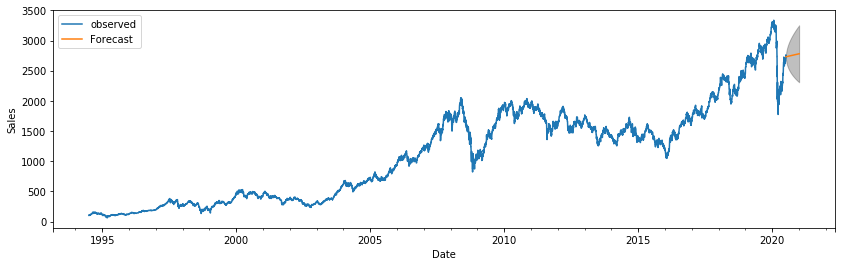

In [254]:
pred_uc = model_fit.get_forecast(steps=180)
pred_ci = pred_uc.conf_int(alpha=0.05)
ax = a.plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

In [230]:
pred_uc = model_fit.get_forecast(steps=30)

In [247]:
pred_uc.predicted_mean.head(5)

2020-07-12    2699.565410
2020-07-19    2709.675085
2020-07-26    2712.556741
2020-08-02    2715.066681
2020-08-09    2718.011232
Freq: W-SUN, dtype: float64

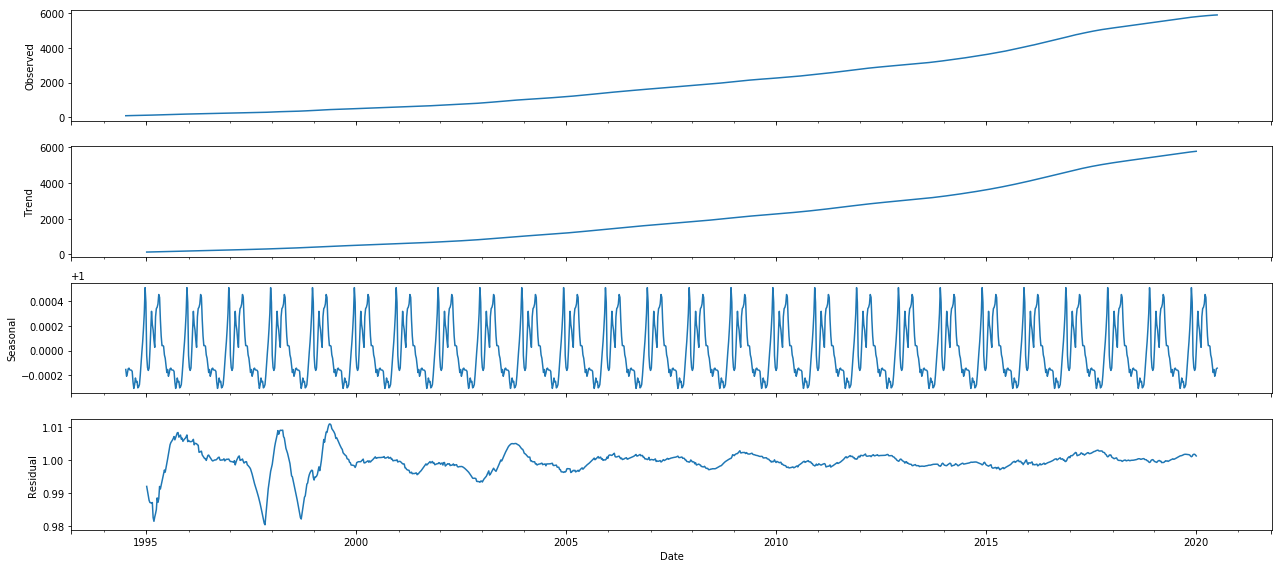

In [147]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(b, model='multiplicative')
fig = decomposition.plot()
plt.show()